In [1]:
"""
Simulation for two-populatio reduced mean-field attractor model
(Wong K-F & Wang X-J, J Neurosci (2006))
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import integrate
from matplotlib import cm
from ipywidgets import interactive


colors = plt.cm.YlOrRd(np.linspace(0, 1, 10))

import warnings
warnings.filterwarnings("ignore")

In [2]:
### Equations from appendix  (only NMDA)

dS_dt = lambda S, tau_s, gamma, H_i : -S/tau_s + (1-S)*gamma*H_i

H = lambda a, b, d, x_i:(a*x_i-b)/(1 - np.exp(-d*(a*x_i-b)))

x = lambda J_Nnn, Sn, J_Nnm, Sm, I0, In, noise: J_Nnn*Sn - J_Nnm*Sm + I0 + In + noise

I1 = lambda JA, mu0, c : JA*mu0*(1 + c/100) 
I2 = lambda JA, mu0, c : JA*mu0*(1 - c/100)


### params from appendix  (only NMDA)


#input– output function
a = 270 #(vNc^-1)
b = 108 #(HZ)
d = 0.154 #(s)

# kinetic
tau_s = 100e-3 #(s)
gamma = 0.641

J_Nnn = 0.2609 #(nA)
J_Nnm = 0.0496 #(nA)
JA = 5.2e-4 #(nA*Hz-1)

I0 = 0.3255 #(nA)
mu0 = 30 #(hz)
noise = 0

c = 0


In [3]:
# ODE
def dx_dt(S, t, c, J_Nnn, J_Nnm, JA, I0, mu0, a, b, d, tau_s, gamma):
    
    S1, S2 = S
        
    x1 = x(J_Nnn, S1, J_Nnm, S2, I0, I1(JA, mu0, c), noise = 1e-3)
    x2 = x(J_Nnn, S2, J_Nnm, S1, I0, I2(JA, mu0, c), noise = 1e-3)

    H1 = H(a, b, d, x1)
    H2 = H(a, b, d, x2)

    S1 = dS_dt (S1, tau_s, gamma, H1)
    S2 = dS_dt (S2, tau_s, gamma, H2) 
    
    return np.array([S1,S2])


In [4]:
params0 = 0, J_Nnn, J_Nnm, JA, I0, mu0, a, b, d, tau_s, gamma
params6 = 6.4, J_Nnn, J_Nnm, JA, I0, mu0, a, b, d, tau_s, gamma
params51 = 51.2, J_Nnn, J_Nnm, JA, I0, mu0, a, b, d, tau_s, gamma
params100 = 100, J_Nnn, J_Nnm, JA, I0, mu0, a, b, d, tau_s, gamma



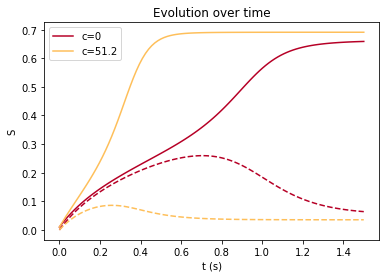

In [5]:

init_s = np.array([0.01, 0])
dt = np.linspace(0, 1.5, 100)
S_t0 = integrate.odeint(dx_dt, init_s, dt, args=params0)
S_t51 = integrate.odeint(dx_dt, init_s, dt, args=params51)

plt.title('Evolution over time')
plt.plot(dt, S_t0[:,0], c=colors[8], label='c=0')
plt.plot(dt, S_t0[:,1], c=colors[8], linestyle="--")

plt.plot(dt, S_t51[:,0], c=colors[3], label='c=51.2')
plt.plot(dt, S_t51[:,1], c=colors[3], linestyle="--")


plt.xlabel('t (s)')
plt.ylabel('S')
plt.legend();

plt.show()

In [6]:
#quiver parameters
size = 500
axis_size = np.linspace(0, 1, size)

## for nulcline
dS0 = np.zeros((size, size, 2))
dS6 = np.zeros((size, size, 2))
dS51 = np.zeros((size, size, 2))
dS100 = np.zeros((size, size, 2))


s1_, s2_ = np.meshgrid(axis_size, axis_size)


t=0
for i, s1_i in enumerate(s1_[0]):
    for j, s2_j in enumerate(s1_[0]):
        
        S0 = np.array([s1_i, s2_j])

        dS0[i,j] = dx_dt(S0, t, *params0)
        dS6[i,j] = dx_dt(S0, t, *params6)
        dS51[i,j] = dx_dt(S0, t, *params51)
        dS100[i,j] = dx_dt(S0, t, *params100)


 

        

In [7]:
def get_nulcline(dS, size=size):
    
    nulc0 = np.where(np.abs(dS[:,:,0])<1e-1, 1, 0)
    nulc1 = np.where(np.abs(dS[:,:,1])<1e-1, 1, 0)
    
    
    nulc0_1d = np.zeros((size))
    nulc1_1d = np.zeros((size))

    for i in range(size):
        for j in range(size):

            if nulc0[i, j]>0:
                nulc0_1d[i]=j

            if nulc1[j, i]>0:
                nulc1_1d[i]=j
            
    
    return (nulc0_1d, nulc1_1d)


In [8]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    
    return arr.reshape(shape).mean(-1).mean(1)



In [9]:
def plot_phase(title, dS, nulc0, nulc1, s1_, s2_, new_size, axis_size):
    
    plt.figure(figsize=(8, 8))
    plt.title(title)
    
    new_shape = (new_size,new_size)
    s1_q, s2_q = np.meshgrid(np.linspace(0, 1, new_size), 
                             np.linspace(0, 1, new_size))
    
    plt.streamplot(s1_q, s2_q, 
               rebin(dS[:,:,1], new_shape), 
               rebin(dS[:,:,0], new_shape), 
           color='grey')

    plt.plot(get_non_zero(norm_0_1(nulc0)),axis_size,
             label=r'$\frac{dS1}{dt}=0$')

    plt.plot(axis_size,get_non_zero(norm_0_1(nulc1)) ,
             label=r'$\frac{dS2}{dt}=0$')

    plt.xlabel('s2')
    plt.ylabel('s1')
    plt.legend(loc='upper right')
    plt.show()

In [10]:
(nulc0_0, nulc1_0)= get_nulcline(dS0)
(nulc0_6, nulc1_6)= get_nulcline(dS6)
(nulc0_51, nulc1_51)= get_nulcline(dS51)     
(nulc0_100, nulc1_100)= get_nulcline(dS100)


In [11]:
norm_0_1 = lambda x:  (x - np.min(x))/np.ptp(x)
get_non_zero = lambda x: np.where(x>0, x, None)



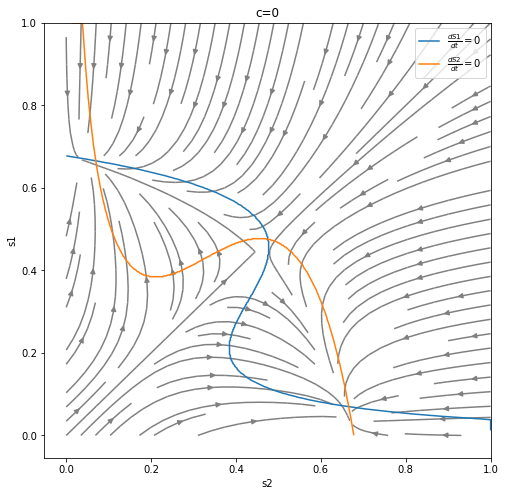

In [12]:
plot_phase('c=0', dS0, nulc0_0, nulc1_0, s1_, s2_, 25,axis_size)

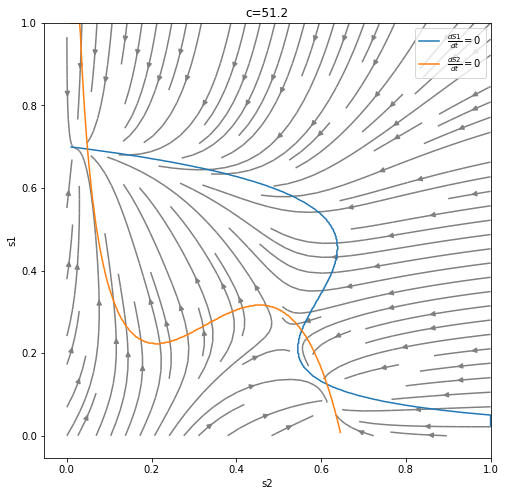

In [13]:
plot_phase('c=51.2', dS51, nulc0_51, nulc1_51, s1_, s2_, 25, axis_size)

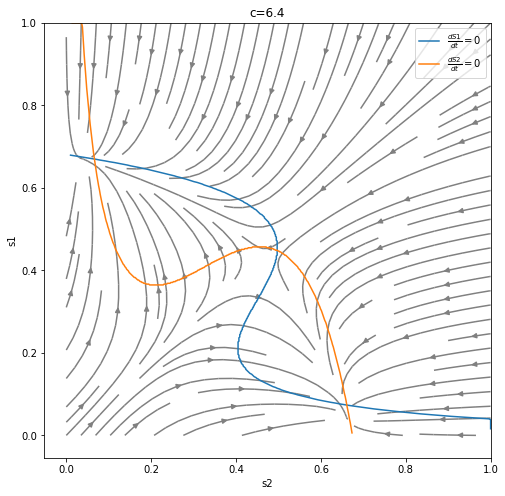

In [14]:
plot_phase('c=6.4', dS6, nulc0_6, nulc1_6, s1_, s2_, 25, axis_size)

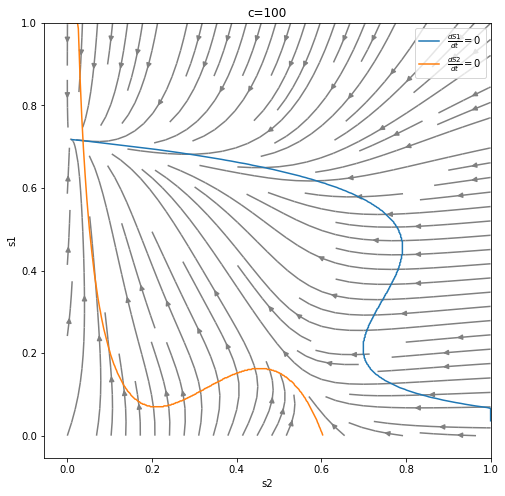

In [15]:
plot_phase('c=100', dS100, nulc0_100, nulc1_100, s1_, s2_, 25, axis_size)

In [16]:
def get_plot(c, mu0=mu0):
    params = c, J_Nnn, J_Nnm, JA, I0, mu0, a, b, d, tau_s, gamma
    
    size = 100
    axis_size = np.linspace(0, 1, size)

    ## for nulcline
    dS = np.zeros((size, size, 2))

    s1_, s2_ = np.meshgrid(axis_size, axis_size)

    t=0
    for i, s1_i in enumerate(s1_[0]):
        for j, s2_j in enumerate(s1_[0]):

            S0 = np.array([s1_i, s2_j])
            dS[i,j] = dx_dt(S0, t, *params)

    (nulc0_, nulc1_)= get_nulcline(dS, size)
    
    plot_phase(r'c={}, $\mu_0$ ={}'.format(c, mu0), dS, 
               nulc0_, nulc1_, s1_, s2_, 
               25, axis_size)



        
    

In [18]:
widget = interactive(get_plot, {'manual': False}, 
                     c=(0,100,10),
                     mu0=(0,100,5))

widget


interactive(children=(IntSlider(value=50, description='c', step=10), IntSlider(value=30, description='mu0', st…